# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Tratamento e limpeza de bases de dados</span>


### <span style="color:darkred">Tratamento de desbalanceamento: subamostragem e aumentação de dados</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

import lightgbm as lgbm

from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import combine

# Dados Desbalanceados

Vamos estudar o problema de dados desbalanceados utilizando o conjunto de dados de natalidade em uma maternidade.

In [2]:
data = pd.read_csv("./dados/TACTD-01-Desbalanceamento.csv")
data.head()

,Sex,Gestational age,Month,Year,Weight,Hospital,Date
0,F,38,12,2016,3740,St Mary,201612
1,M,39,12,2016,4130,St Mary,201612
2,M,42,12,2016,4250,St Mary,201612
3,F,39,12,2016,3990,St Mary,201612
4,F,38,12,2016,3760,St Mary,201612


In [3]:
data['Sex'].value_counts()

F    58
M    18
Name: Sex, dtype: int64

In [4]:
cont = data['Sex'].value_counts()

# relacao entre classe majoritaria e minoritaria
ratio = np.round((cont[1]/cont[0])*10,1)

# percentual
perce = (np.min(cont)/data.shape[0])*100

In [5]:
print('Problema com relaçao 1:'+str(ratio))
print('Classe minoritária com frequência: %.1f%%' % (perce)) 

Problema com relaçao 1:3.1
Classe minoritária com frequência: 23.7%


Nesse caso temos um desbalanceamento de aproximadamente 1:3

Ao inferir modelos temos que tratar a amostra relativa ao Sexo Feminino e ao Sexo Masculino de forma a controlar por essa diferença.

Em alguns métodos de aprendizado, por exemplo, a quantidade de dados é levada em consideração e pode trazer um peso maior para a categoria chamada de *majoritária*, nesse caso o sexo Feminino.


O efeito de desbalanceamento pode causar o deslocamento de uma superfície de decisão aprendida, favorecendo a classe majoritária

<img src="imagens/desb_1_deci.png" width=280>

---



# Métodos de tratamento de desbalanceamento

1. **Subamostragem**: remove exemplos da classe majoritária
2. **Aumentação de dados/sobreamostragem**: cria *novos* exemplos sintéticos/artificiais para a classe minoritária

### Subamostragem aleatória

<img src="imagens/desb_2_unders.png" width=400>


### SMOTE

Método de sobreamostragem *Synthetic Minority Oversampling Technique*

<img src="imagens/desb_3_SMOTE.png" width=600>

### TomekLinks

Método de remoção de exemplos com base no vizinho mais próximo

<img src="imagens/desb_4_tomek.png" width=600>

### Edited Nearest Neighbors (ENN)

Utiliza $k$ vizinhos mais próximos ao invés de um único como no Tomek

---

Vamos utilizar uma base de dados desbalanceada para mostrar alguns métodos

In [6]:
# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("./dados/houses_to_rent_mba_nomissing2.csv")

# tratamento de dados
data_nred = data.drop_duplicates(keep='first').copy()
data_nred.loc[data_nred['floor']=='-','floor'] = '0'
data_nred.loc[:,'floor'] = pd.to_numeric(data_nred['floor'], downcast='integer', errors='coerce')
data_nred.loc[:,'tax'] = pd.to_numeric(data_nred['tax'], downcast='float', errors='coerce')
data_nred = data_nred.dropna()

In [7]:
# remoção de outliers
def remove_outliers(df, attributes, factor=2):
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = df[var].quantile(0.25)
            Q2 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
        
        # apenas inliers segundo IQR
        df = df.loc[(df[var] >= Q1-(IQR*factor)) & (df[var] <= Q3+(IQR*factor)), :]
    return df

attributes = ['tax','insurance', 'hoa', 'rent']
data_out = remove_outliers(data_nred, attributes)

print("Antes: %d, Depois tratamento: %d" % (data_nred.shape[0], data_out.shape[0]))

Antes: 10695, Depois tratamento: 8811


Vamos separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [8]:
frac_trein = 0.8
dtrain = data.sample(frac=frac_trein, random_state=1)
dtest = data.drop(dtrain.index)

### Caso multiclasse com uma majoritária

1. classificador para predizer a **cidade** com base no imposto, valor do condomínio e valor do seguro, e valor do condomínio

In [9]:
# Treinando classificador
X = dtrain[['tax','insurance', 'hoa']]
Y = dtrain['city']

ZX = dtest[['tax','insurance', 'hoa']]
ZY = dtest['city']

clf = SVC(gamma='auto')
clf.fit(X,Y)
ZY_ = clf.predict(ZX)

In [10]:
acc_base = metrics.accuracy_score(ZY, ZY_)
accb_base = metrics.balanced_accuracy_score(ZY, ZY_)
print("Acurácia: %0.2f" % (acc_base*100))
print("Acurácia balanceada: %0.2f" % (accb_base*100))

Acurácia: 61.79
Acurácia balanceada: 28.88


<AxesSubplot:>

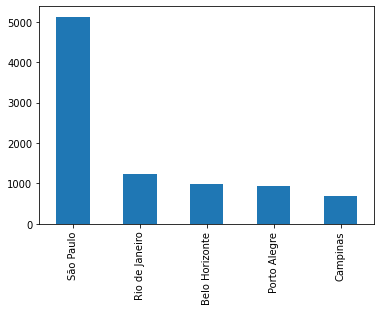

In [11]:
dtrain['city'].value_counts().plot.bar()

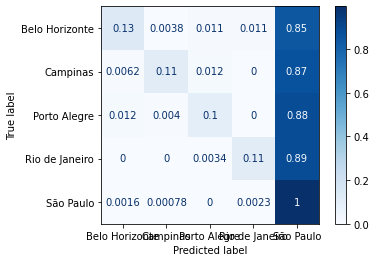

In [12]:
disp = ConfusionMatrixDisplay.from_estimator(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Definimos uma estratégia de amostragem (se deixado em branco vai tentar igualar todas as classes) 

In [13]:
# superamostrando a 50% da majoritária

majority_n = dtrain['city'].value_counts()['São Paulo']

sampling_strategy = {}
for city in dtrain['city'].value_counts().index:
    if city != 'São Paulo':
        sampling_strategy[city] = int(0.5*majority_n)

print(sampling_strategy)

{'Rio de Janeiro': 2564, 'Belo Horizonte': 2564, 'Porto Alegre': 2564, 'Campinas': 2564}


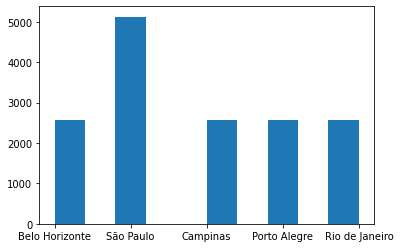

In [14]:
oversamp = over_sampling.SMOTE(sampling_strategy=sampling_strategy) # sampling_strategy pode ser usado para casos binários
Xo, Yo = oversamp.fit_resample(X, Y)
h = plt.hist(Yo)

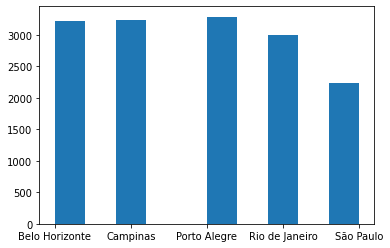

In [15]:
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(X, Y)

h = plt.hist(Yc)

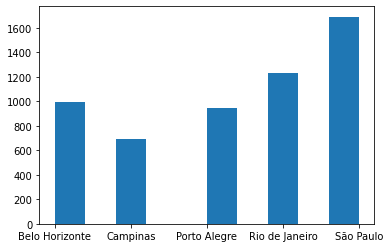

In [16]:
# subamostrando a 33% da majoritária
undersampling_strategy = {'São Paulo': int(0.33*majority_n)}

undersamp = under_sampling.RandomUnderSampler(sampling_strategy=undersampling_strategy)
Xu, Yu = undersamp.fit_resample(X, Y)

h = plt.hist(Yu) 

In [17]:
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(ZX)

clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(ZX)

clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(ZX)

In [18]:
accb_ov = metrics.balanced_accuracy_score(ZY, ZYov_)
accb_un = metrics.balanced_accuracy_score(ZY, ZYun_)
accb_co = metrics.balanced_accuracy_score(ZY, ZYco_)
print("Acurácia balanceada base: %0.3f" % (accb_base))
print("- oversampling (SMOTE): %0.3f" % (accb_ov))
print("- undersampling: %0.3f" % (accb_un))
print("- oversampling + undersampling (SMOTEENN): %0.3f" % (accb_co))

Acurácia balanceada base: 0.289
- oversampling (SMOTE): 0.318
- undersampling: 0.313
- oversampling + undersampling (SMOTEENN): 0.349


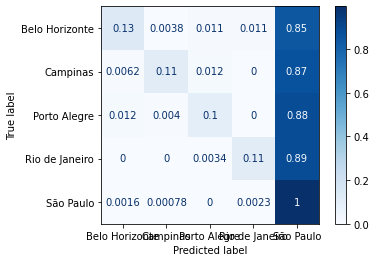

In [19]:
disp = ConfusionMatrixDisplay.from_estimator(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

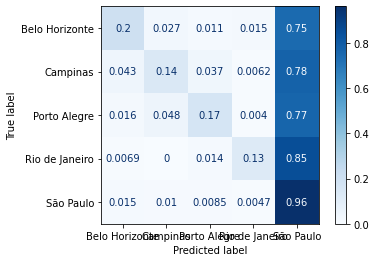

In [20]:
disp = ConfusionMatrixDisplay.from_estimator(clf_ov, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

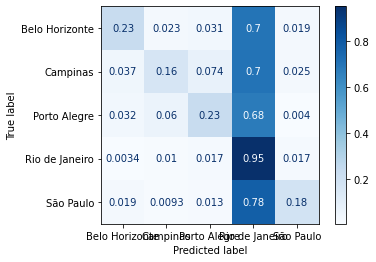

In [21]:
disp = ConfusionMatrixDisplay.from_estimator(clf_co, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

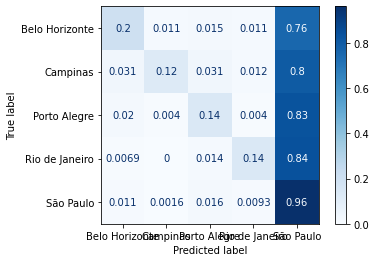

In [22]:
disp = ConfusionMatrixDisplay.from_estimator(clf_un, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Sem reamostragem : ponderando classes no treinamento

Alguns classificadores possuem a opção `class_weight` (ver documentação para detalhes), que permite calcular pesos com base na quantidade de dados, ou um dicionário com os pesos individuais

### Caso binário

In [23]:
dbinary = pd.concat([dtrain[dtrain.city=='São Paulo'], dtrain[dtrain.city=='Campinas'].sample(frac=0.4)])
dbinary_test = pd.concat([dtrain[dtrain.city=='São Paulo'], dtrain[dtrain.city=='Campinas'].sample(frac=0.3)])

In [24]:
dbinary.city.value_counts(1)

São Paulo    0.948927
Campinas     0.051073
Name: city, dtype: float64

In [25]:
dbinary_test.city.value_counts(1)

São Paulo    0.9612
Campinas     0.0388
Name: city, dtype: float64

In [26]:
Xb = dbinary[['tax','insurance', 'hoa']]
Yb = dbinary['city']

ZXb = dbinary_test[['tax','insurance', 'hoa']]
ZYb = dbinary_test['city']

#### Logistic Regression

In [27]:
## classificador caso base
clf_b = LogisticRegression()
clf_b.fit(Xb,Yb)
ZYb_ = clf_b.predict(ZXb)
accb_b = metrics.balanced_accuracy_score(ZYb, ZYb_)

In [28]:
clf_cw = LogisticRegression(class_weight={'São Paulo':1, 'Campinas':10})
clf_cw.fit(Xb,Yb)
ZYcw_ = clf_cw.predict(ZXb)
accb_cw10 = metrics.balanced_accuracy_score(ZYb, ZYcw_)

In [29]:
clf_cw = LogisticRegression(class_weight={'São Paulo':1, 'Campinas':100})
clf_cw.fit(Xb,Yb)
ZYcw_ = clf_cw.predict(ZXb)
accb_cw100 = metrics.balanced_accuracy_score(ZYb, ZYcw_)

In [30]:
clf_bal = LogisticRegression(class_weight='balanced')
clf_bal.fit(Xb,Yb)
ZYbal_ = clf_bal.predict(ZXb)
accb_bal = metrics.balanced_accuracy_score(ZYb, ZYbal_)

In [31]:
print("Logistic Regression")
print("Acurácia balanceada base: %0.2f" % (accb_b*100))
print("- ponderação classes 1/10: %0.2f" % (accb_cw10*100))
print("- ponderação classes 1/100: %0.2f" % (accb_cw100*100))
print("- parametro balanceamento: %0.2f" % (accb_bal*100))

Logistic Regression
Acurácia balanceada base: 50.00
- ponderação classes 1/10: 73.69
- ponderação classes 1/100: 66.98
- parametro balanceamento: 73.62


#### Classificador LightGBM

In [32]:
clf_lgbm = lgbm.LGBMClassifier().fit(Xb,Yb)
clf_lgbm_cw10 = lgbm.LGBMClassifier(class_weight={'São Paulo':1, 'Campinas':10}).fit(Xb,Yb)
clf_lgbm_cw100 = lgbm.LGBMClassifier(class_weight={'São Paulo':1, 'Campinas':100}).fit(Xb,Yb)
clf_lgbm_bal = lgbm.LGBMClassifier(class_weight='balanced').fit(Xb,Yb)

In [33]:
LGB_ZYb_ = clf_lgbm.predict(ZXb)
LGB_ZYcw_ = clf_lgbm_cw10.predict(ZXb)
LGB_ZYcw1_ = clf_lgbm_cw100.predict(ZXb)
LGB_ZYbal_ = clf_lgbm_bal.predict(ZXb)

lgb_b = metrics.balanced_accuracy_score(ZYb, LGB_ZYb_)
lgb_cw = metrics.balanced_accuracy_score(ZYb, LGB_ZYcw_)
lgb_cw1 = metrics.balanced_accuracy_score(ZYb, LGB_ZYcw1_)
lgb_bal = metrics.balanced_accuracy_score(ZYb, LGB_ZYbal_)
print("LightGBM")
print("Acurácia balanceada base: %0.2f" % (lgb_b*100))
print("- ponderação classes 1/10: %0.2f" % (lgb_cw*100))
print("- ponderação classes 1/100: %0.2f" % (lgb_cw1*100))
print("- parametro balanceamento: %0.2f" % (lgb_bal*100))

LightGBM
Acurácia balanceada base: 81.84
- ponderação classes 1/10: 89.73
- ponderação classes 1/100: 89.37
- parametro balanceamento: 89.33


## Resumo

* desbalanceamento também pode ser um problema relevante em bases de dados reais
* ganhos significativos podem ser obtidos por meio de métodos de amostragem
* recomenda-se inicialmente o uso de subamostragem de classes majoritárias ou a ponderação de classes

